In [9]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import time


os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
device = 'cuda'

In [10]:
from siren_pytorch import SirenNet
model = SirenNet(
    dim_in = 2,                        # input dimension, ex. 2d coor
    dim_hidden = 64,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 3,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 3.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
).to(device)

In [11]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)
        return x, y

def flatten_list(list_of_lists, flat_list=[]):
    if not list_of_lists:
        return flat_list
    else:
        for item in list_of_lists:
            if type(item) == list:
                flatten_list(item, flat_list)
            else:
                flat_list.append(item)

    return flat_list

In [30]:
class Solver():
    def __init__(self, model, ics_sampler, bcs_sampler, res_sampler, c):

        self.model = model.to(device)
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler
        self.c = c

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        X, _ = self.res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)

        self.loss_bcs_log = []
        self.loss_res_log = []
        self.loss_ut_ics_log = []

        self.lam_u_log = []
        self.lam_ut_log = []
        self.lam_r_log = []

    def nn_autograd_simple(self, points, order,axis=0):
        points.requires_grad=True
        f = self.model(points).sum().to(device)
        for i in range(order):
            grads, = torch.autograd.grad(f, points, create_graph=True)
            f = grads[:,axis].sum()
        return grads[:,axis]

    def wave_op(self, points):
        u_t = self.nn_autograd_simple(points, order = 1, axis=0)
        u_xx = self.nn_autograd_simple(points, order = 2, axis=1)
        operator = u_t - self.c**2 * u_xx
        return operator

    def fetch_minibatch(self, sampler, N):
        X, y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X[:N], y[:N]

    def list_to_vector(self, list_):
        return torch.cat([x.reshape(-1) for x in list_])

    def jacobian(self, f):
        jac = []
        for i in range(len(f)):
            f[i].backward(retain_graph=True)
            deriv = [w.grad.reshape(-1).to(device) if w.grad is not None else torch.tensor([0]).to(device) for w in self.model.parameters()]
            jac.append(self.list_to_vector(deriv))
        jac = torch.vstack(jac)
        return jac

    def compute_ntk(self, J1, J2):
        return J1 @ J2.T

    def loss_bnd_op(self, X_bcs_1, X_bcs_2, X_ics, y_ics):
        bnd1 = self.model(X_bcs_1)
        bnd2 = self.model(X_bcs_2)
        ics = self.model(X_ics)

        loss_bnd1 = torch.mean(torch.square(bnd1))
        loss_bnd2 = torch.mean(torch.square(bnd2))
        loss_ics = torch.mean(torch.square(ics - y_ics))

        loss_bnd = loss_bnd1 + loss_bnd2 + loss_ics
        return loss_bnd

    def train(self, epochs=10000, batch_size=128, update_lam=False):
        lb, lr, li = 1,1,1
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optimizer, gamma=0.9)
        for iter in range(epochs):
            self.optimizer.zero_grad()
            X_ics, y_ics = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bcs_1, y_bcs_1 = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bcs_2, y_bcs_2 = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            X_res, y_res = self.fetch_minibatch(self.res_sampler, batch_size)

            op = self.wave_op(X_res)
            loss_op = torch.mean(torch.square(op))
            loss_bnd = self.loss_bnd_op(X_bcs_1, X_bcs_2, X_ics, y_ics)
            loss = lr * loss_op + lb * loss_bnd 
            loss.backward()

            self.optimizer.step()
            if iter % 1000 == 0:
                scheduler.step()
                print(scheduler.get_last_lr())

            if iter % 100 == 0:
                self.loss_bcs_log.append(loss_bnd)
                self.loss_res_log.append(loss_op)

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e' %
                      (iter, loss, loss_op.item(), loss_bnd))

                print('lambda_u: {:.3e}'.format(lb))
                print('lambda_r: {:.3e}'.format(lr))

                if update_lam:
                    bcs = torch.vstack([X_bcs_1,X_bcs_2,X_ics])
                    X_ics, y_ics = self.fetch_minibatch(self.ics_sampler, batch_size)

                    u_ntk = self.model(bcs)
                    r_ntk = self.wave_op(X_res)



                    J_u = self.jacobian(u_ntk)
                    J_r = self.jacobian(r_ntk)

                    K_u = self.compute_ntk(J_u,J_u)
                    K_r = self.compute_ntk(J_r, J_r)

                    trace_K = torch.trace(K_u)  +\
                                           torch.trace(K_r)

                    lb = trace_K / torch.trace(K_u)
                    lr = trace_K / torch.trace(K_r)

                    # # Store NTK weights
                    self.lam_u_log.append(lb)
                    self.lam_r_log.append(lr)

    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        u_star = self.model(X_star).to('cpu')
        return u_star

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        r_star = self.wave_op(X_star).to('cpu')
        return r_star

    def model(self):
        return self.model

In [31]:
#Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + \
            a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) - \
            a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
            a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
              a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_t(x, a, c) - c**2 * u_xx(x, a, c)

In [32]:
a = 0.5
c = 2

ics_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')

model = torch.nn.Sequential(
    torch.nn.Linear(2, 500),
    torch.nn.Tanh(),
    torch.nn.Linear(500, 500),
    torch.nn.Tanh(),
    torch.nn.Linear(500, 500),
    torch.nn.Tanh(),
    torch.nn.Linear(500, 1)
)
model = Solver(model, ics_sampler, bcs_sampler, res_sampler,c=c)

itertaions = 80001
update_lam = False

In [33]:
start = time.time()
model.train(epochs=itertaions, update_lam=update_lam)
end = time.time()

[9e-05]
It: 0, Loss: 7.013e-01, Loss_res: 2.269e-03,  Loss_bcs: 6.990e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 100, Loss: 1.994e-01, Loss_res: 2.044e-02,  Loss_bcs: 1.789e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 200, Loss: 2.453e-01, Loss_res: 2.561e-02,  Loss_bcs: 2.197e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 300, Loss: 1.825e-01, Loss_res: 1.033e-02,  Loss_bcs: 1.722e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 400, Loss: 1.596e-01, Loss_res: 1.594e-02,  Loss_bcs: 1.436e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 500, Loss: 1.932e-01, Loss_res: 1.170e-02,  Loss_bcs: 1.815e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 600, Loss: 1.786e-01, Loss_res: 1.497e-02,  Loss_bcs: 1.636e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 700, Loss: 1.493e-01, Loss_res: 1.205e-02,  Loss_bcs: 1.372e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 800, Loss: 1.423e-01, Loss_res: 7.115e-03,  Loss_bcs: 1.352e-01
lambda_u: 1.000e+00
lambda_r: 1.000e+00
It: 900, Loss: 1.013e-

662.6188378334045


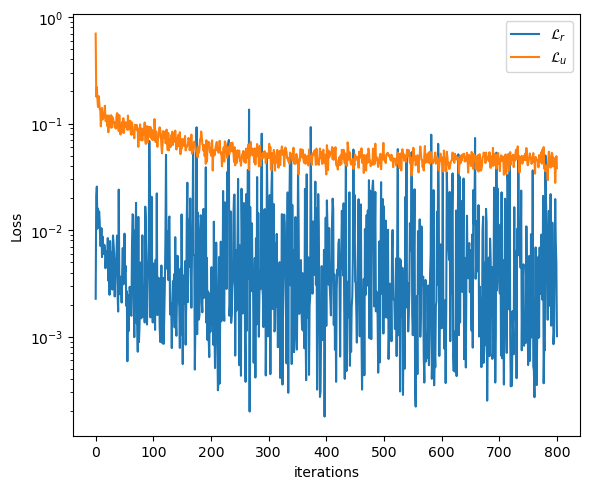

In [35]:

print(end-start)

loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

loss_res = list(map(lambda x: x.item(),loss_res))
loss_bcs = list(map(lambda x: x.item(),loss_bcs))

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('torch_upd_lam=True.png',dpi=100)
plt.show()

Relative L2 error_u: 9.087005e-02


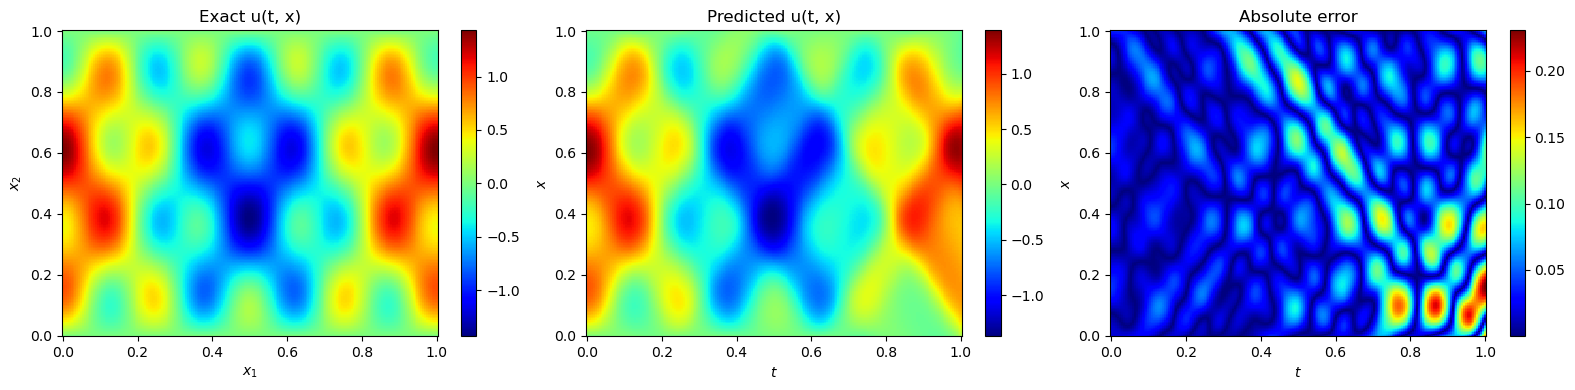

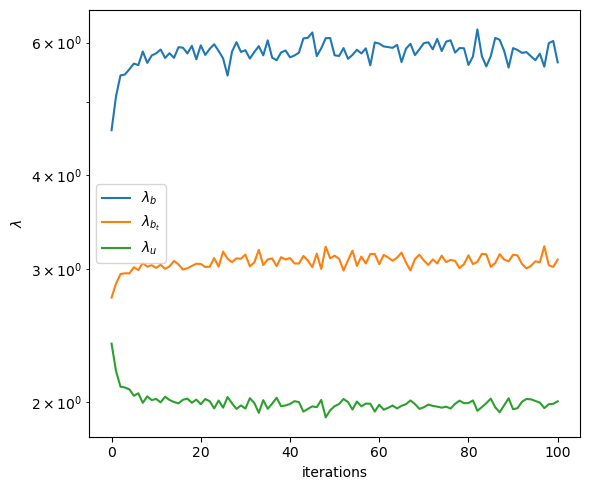

In [8]:
nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))
X_star = torch.from_numpy(X_star).float().to(device)

u_star = u(X_star.cpu(), a,c)
R_star = r(X_star.cpu(), a, c)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star.numpy() - u_pred.detach().numpy(), 2) / np.linalg.norm(u_star.numpy(), 2)

print('Relative L2 error_u: %e' % (error_u))



U_star = griddata(X_star.cpu(), u_star.flatten(), (t, x), method='cubic')
R_star = griddata(X_star.cpu(), R_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star.cpu(), u_pred.detach().numpy().flatten(), (t, x), method='cubic')
R_pred = griddata(X_star.cpu(), r_pred.detach().numpy().flatten(), (t, x), method='cubic')


plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('result_torch_upd_lam=True.png',dpi=100)
plt.show()


lam_u_log = model.lam_u_log
lam_ut_log = model.lam_ut_log
lam_r_log = model.lam_r_log

lam_u_log = list(map(lambda x: x.item(),lam_u_log))
lam_ut_log = list(map(lambda x: x.item(),lam_ut_log))
lam_r_log = list(map(lambda x: x.item(),lam_r_log))

plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_b$')
plt.plot(lam_ut_log, label='$\lambda_{b_t}$')
plt.plot(lam_r_log, label='$\lambda_{u}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('torch_lambda.png', dpi=100)
plt.show()

# Test
u''(x) = sin(px)
u(x) = -p^2sin(px)
u(0) = u(1) = 0

In [92]:
from siren_pytorch import SirenNet
model = SirenNet(
    dim_in = 1,                        # input dimension, ex. 2d coor
    dim_hidden = 1000,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 1,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 3.                   # different signals may require different omega_0 in the first layer - this is a hyperparameter
).to(device)

In [115]:
model = FourLayersNet(10000).to(device)

In [118]:
def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

def jacobian(f, model):
    jac = []
    for i in range(len(f)):
        f[i].backward(retain_graph=True)
        deriv = [w.grad.reshape(-1).to(device) if w.grad is not None else torch.tensor([0]).to(device) for w in model.parameters()]
        jac.append(list_to_vector(deriv))
    jac = torch.vstack(jac)
    return jac

def compute_ntk(J1, J2):
    return J1 @ J2.T

In [119]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 1)
).to(device)

In [120]:
x = torch.linspace(0,1,20).reshape(-1,1).to(device)
x_b = torch.tensor([0,1]).reshape(-1,1).to(device).float()
f = np.pi*torch.cos(np.pi*x).to(device)
g = torch.zeros((2,1)).to(device)

lossfn = nn.MSELoss(reduction='mean')
opt = torch.optim.SGD(model.parameters(), 0.001)

tensor(490.0180, device='cuda:0') tensor(1.0020, device='cuda:0')
0 || loss:8.260181427001953 loss b:0.0061803036369383335 loss r:5.221044540405273
tensor(10.4932, device='cuda:0') tensor(1.1053, device='cuda:0')
1 || loss:40.171993255615234 loss b:3.345513343811035 loss r:4.583880424499512
tensor(13.2725, device='cuda:0') tensor(1.0815, device='cuda:0')
2 || loss:15.643426895141602 loss b:0.7832695841789246 loss r:4.852105617523193
tensor(15.2586, device='cuda:0') tensor(1.0701, device='cuda:0')
3 || loss:6.91813850402832 loss b:0.09906260669231415 loss r:5.052253246307373
tensor(25.8686, device='cuda:0') tensor(1.0402, device='cuda:0')
4 || loss:5.555056095123291 loss b:0.008256233297288418 loss r:5.134994029998779
tensor(52.5262, device='cuda:0') tensor(1.0194, device='cuda:0')
5 || loss:5.297048568725586 loss b:0.0005218333681114018 loss r:5.169314384460449
tensor(456.7292, device='cuda:0') tensor(1.0022, device='cuda:0')
6 || loss:5.66956901550293 loss b:0.0011253722477704287 loss

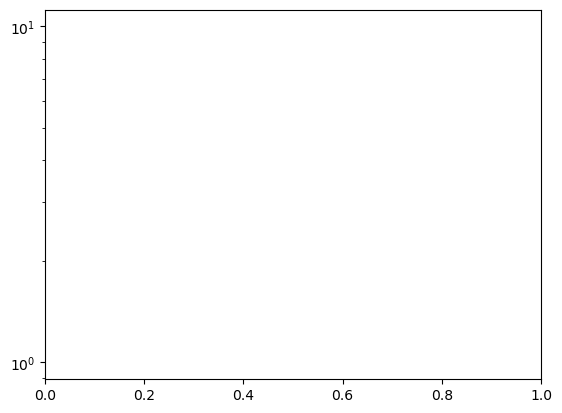

In [121]:
lb,lr = 1,1
for i in range(1000):
    x_r = x.clone()
    x_r.requires_grad = True
    u = model(x_r)
    u_b = model(x_b)
    u_x = torch.autograd.grad(u.sum(),x_r,create_graph=True)[0]
    #u_xx = torch.autograd.grad(u_x.sum(),x_r,create_graph=True)[0]

    #u = torch.cat((u_b,u_xx), dim=0)
    Ju = jacobian(u_b,model)
    Jr = jacobian(u_x,model)
    K_u = compute_ntk(Ju,Ju)
    K_r = compute_ntk(Jr,Jr)

    trace_K = torch.trace(K_u) + torch.trace(K_r)

    lb = trace_K / torch.trace(K_u)
    lr = trace_K / torch.trace(K_r)
    print(lb,lr)




    loss_r = lossfn(u_x,f)
    loss_b = lossfn(u_b,g) 
    loss = lb*loss_b + lr*loss_r
    print(i, f'|| loss:{loss.item()}', f'loss b:{loss_b.item()}', f'loss r:{loss_r.item()}')
    opt.zero_grad()
    loss.backward()
    opt.step()
plt.yscale('log')

In [118]:
K = torch.concatenate([torch.concatenate([Ku, Kur], axis = 1),
                        torch.concatenate([Kur.T, Kr], axis = 1)], axis = 0)
lr = torch.trace(K)/torch.trace(Kr)
lb = torch.trace(K)/torch.trace(Ku)
Nb = x_b.shape[0]
Nr = x.shape[0]
K_ = torch.concatenate([torch.concatenate([(lb/Nb)*Ku, (lr/Nr)*Kur], axis = 1),
                        torch.concatenate([(lb/Nb)*Kur.T, (lr/Nr)*Kr], axis = 1)], axis = 0)
torch.det(K)
torch.det(K_)

tensor(-0., device='cuda:0')

In [119]:
LK = np.linalg.cholesky(K.cpu().numpy()+0.0005* np.eye(x.shape[0]+2))

In [120]:

L_help = np.linalg.solve(LK, K_test.cpu().numpy().T)


In [112]:
L_help.shape

(22, 10)

In [121]:
L_help.T@(a.cpu().numpy())

array([[-243.1907332 ],
       [-240.39578248],
       [-235.40646793],
       [-229.50751488],
       [-224.07538179],
       [-224.46884991],
       [-232.35701449],
       [-253.86989558],
       [-276.56289101],
       [-293.80781308]])

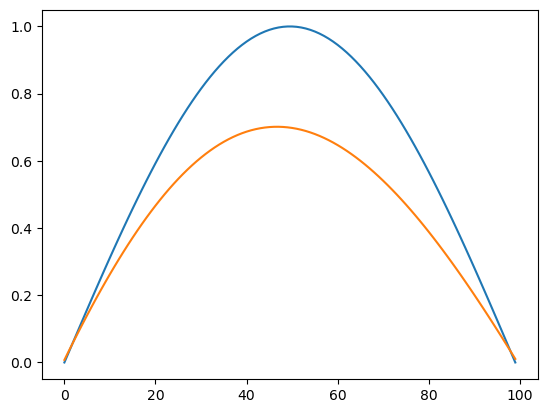

In [80]:
x_pred = torch.linspace(0,1,100).reshape(-1,1).to(device)
u_pred = model(x_pred)
plt.plot(torch.sin(np.pi*x_pred).cpu().numpy())
plt.plot(u_pred.cpu().detach().numpy())

In [100]:
x_test  = torch.linspace(0,1,5).reshape(-1,1).to(device)
x_test.requires_grad = True
u = model(x_test)
u_x = torch.autograd.grad(u.sum(),x_test,create_graph=True)[0]
u_xx = torch.autograd.grad(u_x.sum(),x_test,create_graph=True)[0]

In [102]:
J_test = jacobian(torch.cat((u,u_xx), dim=0),model)
J = torch.concatenate([Ju, Jr], axis = 0)
K_test = compute_ntk(J_test, J)

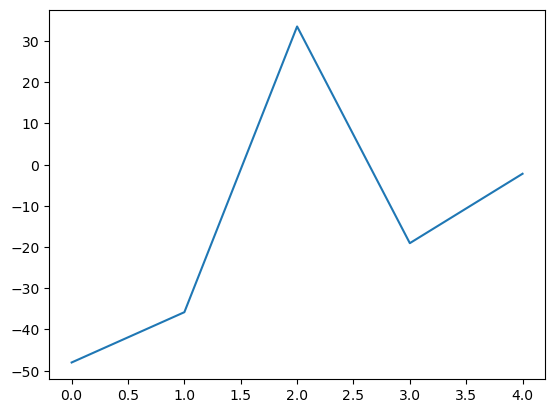

In [106]:
a = torch.cat((g,f), dim=0)
plt.plot((K_test@torch.linalg.inv(K)@a)[:5].cpu().numpy())